# Imports

In [1]:
!pip install seaborn_qqplot
!pip install pyarrow

import os
os.chdir('../functions')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cluster_data import *
from gmm import *
from utility import *
# from visualization import *
from scipy import stats
from seaborn_qqplot import pplot

sns.set(style='whitegrid', rc = {'figure.figsize':(15,8)})

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached seaborn_qqplot-0.5.0-py3-none-any.whl (12 kB)
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


# Read functions

In [2]:

def read_generated_sample(path, t=30):
    # read the data
    sample = pd.read_csv(path, header=None).to_numpy()
    #post process data
    sample = np.exp(sample.reshape(-1, 96))
    
    # set a treshold for high outliers for visualizing purposes
    max = np.full(sample.shape, t)
    post_sample = np.minimum(sample, max)
    
    return post_sample

# Helper functions

In [3]:
#real, gmm, timegan

    
def preprocess_data(data):
    # + e-7 because log(0)==inf
    log_data = np.log(data + 1e-7)
    return log_data


def plot_distribution(data, log_data, dt_string):
    #get the date
    date = dt_string.split(' ')[0]
    n_bins = 50
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
    data = data.reshape(-1)
    bins = np.linspace(data.min(), data.max(),n_bins)
    ax1.hist(data, bins)
    ax1.set_xlabel('Load (kwh)')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'(a) Distribution of the data across all profiles for the day {date}')
  
    log_data = log_data.reshape(-1)
    bins = np.linspace(log_data.min(), log_data.max(),n_bins)
    ax2.hist(log_data, bins)
    ax2.set_xlabel('Load (kwh)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'(b) Distribution of log of the data across all profiles for the day {date}')
    fig.show() 


def perform_kstest(real, generated):
    #perform the two-sample ks test
    dstat, pvalue = stats.ks_2samp(real, generated)
    return dstat

def compare_cdfs(ori_data, gen_data, timegan_data):
    # sort the data in ascending order
   
    ori_sample = ori_data.reshape(-1)
    gen_sample = gen_data.reshape(-1)
    
    # sort the data in ascending order
    ori = np.sort(ori_sample)
    gen = np.sort(gen_sample)
    
    # get the cdf values of y
    y = np.arange(len(ori)) / float(len(ori))

    # plotting
    plt.xlabel('load')
    plt.ylabel('cumulative distribution')

    plt.title('CDF comparison')

    plt.plot(ori, y,  label='original')
    plt.plot(gen, y,  label='generated')
    plt.legend()
    plt.show()

    

    

def get_combined_df(ori_data, generated_data, timegan_data, start_dt, end_dt, resample_v='15min'):
    
    # make df of original data
    ori_df = make_tidy( make_df(ori_data, start_dt, end_dt), resample_v)
    ori_df.loc[:,'type'] = 'real'

    # make df of generated (gmm) data
    gen_df = make_tidy( make_df(generated_data, start_dt, end_dt), resample_v)
    gen_df.loc[:,'type'] = 'gmm'
    
    # make df of generated (timegan) data
    timegan_df = make_tidy( make_df(timegan_data, start_dt, end_dt), resample_v)
    timegan_df.loc[:,'type'] = 'timegan'

    #merge dfs
    df = pd.concat([ori_df, gen_df, timegan_df])

    df.loc[:, 'hour'] = [d.hour for d in df.index]
    df.loc[:, 'minute'] = [d.minute for d in df.index]
    df.loc[:, 'hour-day'] = [f'{d.hour}:00({d.day})' for d in df.index]
    return df

def make_tidy(df, resample_v='60min'):
    return (
        df
        .resample(resample_v)  # todo: maak '60min' variabel
        .mean()
        .reset_index()
        .melt(id_vars='dt', var_name='profile', value_name='verbruik')
        .set_index('dt')
        [['verbruik', 'profile']]
    )
    

    

def compare_one_metric(metric, title1, title2, **args):
    dfs = []
    for key in args:
        df = get_combined_df(args[key][0], args[key][1], args[key][2], start_dt, end_dt)
        df.loc[:, 'experiment'] = key
        dfs.append(df)
    # combine all the experiments
    df = pd.concat(dfs)
    df_agg = (
        df
        .reset_index()
        .groupby(['dt', 'type', 'hour-day'])
        .agg({
           'load (kW)' : ['median', percentile(25), percentile(75), 'max']
        })
        .droplevel(0, axis=1)
        .reset_index()
        .melt(id_vars=['dt', 'type', 'Time (hour of the day)'], value_vars= [ 'percentile_25', 'median', 'percentile_75'], value_name='metric')
    )
    lineplot = sns.relplot(data=df_agg[df_agg.metric=='median'], x='hour-day', y='verbruik', hue='type', kind='line', estimator=np.median, col='experiment')
    fig = lineplot.fig
    fig.set_size_inches(18.5, 7.5)
    a0 = fig.axes[0]
    a0.ax.tick_params(axis='x', rotation=45)
    
    a1 = fig.axes[0]
    a1.set_title("Results on scaled data (21-01)")
    a1.ax.tick_params(axis='x', rotation=45)
    


def plot_hour_difference(real, gmm, timegan, hours, title, x, dvalue):
    sample = np.random.choice(range(len(real)), size=len(real), replace=False)    
    gmm = gmm[sample,:]
    timegan = timegan[sample,:]
    # hour
    real_dis = real[:, (hours*4)+1] - real[:, hours*4]
    gmm_dis = gmm[:, (hours*4)+1] -  gmm[:, hours*4]
    timegan_dis = timegan[:, (hours*4)+1] -  timegan[:, hours*4]
    
    compare_distibutions(real_dis, gmm_dis, timegan_dis, title, x, dvalue)


# Read all the generated samples that we want to evaluate

In [4]:
data_path = '../data'
generated_samples_path = f'{data_path}/generated_samples'

In [5]:
print('available setting options:')
set(['_'.join(name) for name in [file.split('.')[0].split('_')[1:] for file in os.listdir(generated_samples_path)]])

available setting options:


{'',
 '1706_norm',
 '1706_scaled',
 '1906_scaled',
 '2101_h32_d4',
 '2101_norm',
 '2101_scaled',
 '2101_scaled_2d',
 '2101_scaled_h16',
 '2101_scaled_h24',
 '2101_scaled_h36',
 '2301_scaled'}

# Settings
The available setting options are listed above (files in the generated_samples folder). 

example: '2101_scaled' means that the models have been trained with scaled profiles as input with januray 21 as starting point, for 1 day (default)

'2101_scaled_2d' := the 2d here means that the profiles consists of 2 consecutive (d)ays

'2101_scaled_h24' := the h24 means that the timegan model has been trained with an (h)idden dimension parameter of 24

In [6]:
setting = '2301_scaled' 
start_dt, end_dt = '2021-01-23 00:00:00', '2021-01-23 23:45:00' 

## Load the data

In [7]:
real = read_generated_sample(f'{generated_samples_path}/real_{setting}.csv')
gmm = read_generated_sample(f'{generated_samples_path}/gmm_{setting}.csv')
timegan = read_generated_sample(f'{generated_samples_path}/timegan_{setting}.csv')

# get the same amount of samples as the real profiles
n_profiles = real.shape[0]

gmm = gmm[:n_profiles,:]
timegan = timegan[:n_profiles,:]

# Data visualizations 

## Data distribution, before and after the log transformation

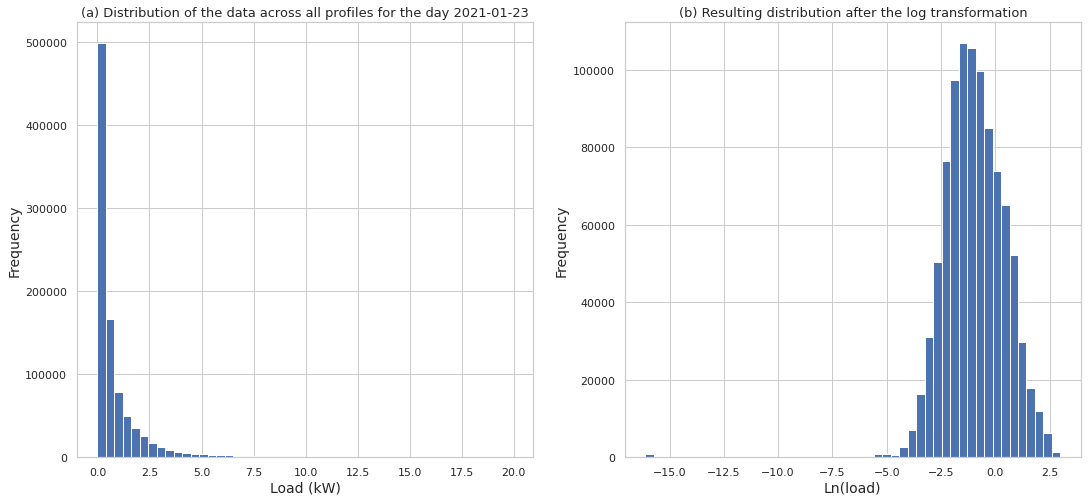

In [8]:
def plot_distribution(data, log_data, dt_string):
    axis_fs=14
    title_fs= 13
    #get the date
    date = dt_string.split(' ')[0]
    n_bins = 50
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
    data = data.reshape(-1)
    bins = np.linspace(data.min(), data.max(),n_bins)
    ax1.hist(data, bins)
    ax1.set_xlabel('Load (kW)', fontsize=axis_fs)
    ax1.set_ylabel('Frequency', fontsize=axis_fs)
    ax1.set_title(f'(a) Distribution of the data across all profiles for the day {date}', fontsize=title_fs)
  
    log_data = log_data.reshape(-1)
    bins = np.linspace(log_data.min(), log_data.max(),n_bins)
    ax2.hist(log_data, bins)
    ax2.set_xlabel('Ln(load)', fontsize=axis_fs)
    ax2.set_ylabel('Frequency', fontsize=axis_fs)
    ax2.set_title(f'(b) Resulting distribution after the log transformation', fontsize=title_fs)
    fig.show()

# laad de dataset waarbij de log transformatie nog niet ongedaan gemaakt is, dus de dataset waar ook op getraind is
real_log = pd.read_csv(f'{generated_samples_path}/real_{setting}.csv', header=None).to_numpy() 
# extreme outliers verwijderen voor een mooiere plot
# real_log = np.maximum(-8, real_log)

plot_distribution(real, real_log, start_dt)

## Correlation between consecutive time steps

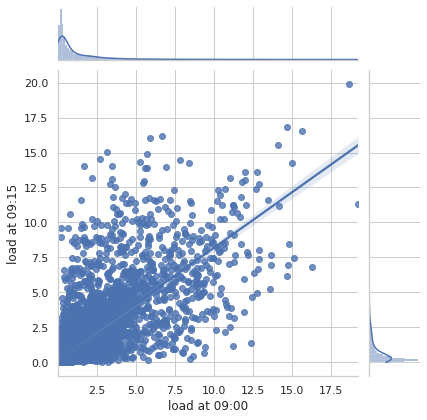

correlation: 0.7622191533863057


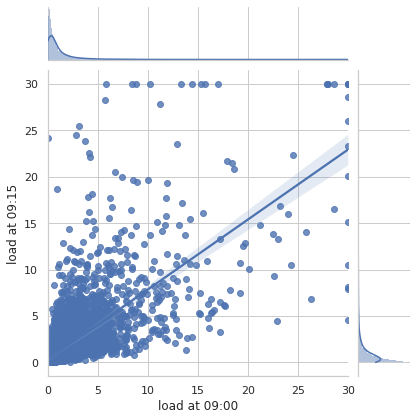

correlation: 0.7332541394541574


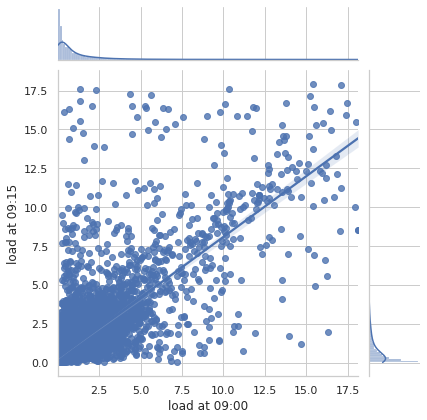

correlation: 0.7584266075074021


In [9]:
def plot_correlations(data):
    real_11 = data[:,4*9].reshape(-1)
    real_11_15 = data[:,(4*9)+1].reshape(-1)
    

    df= pd.DataFrame({'load at 09:00': real_11, 'load at 09:15': real_11_15})
    sns.jointplot(data=df, x="load at 09:00", y="load at 09:15", kind='reg')
    plt.xlabel('Load at 09:00', fontsize=13)
    plt.ylabel('Load at 09:15', fontsize=13)
    plt.show()
    
    print(f'correlation: {np.corrcoef(real_11, real_11_15)[0,1]}')
plot_correlations(real)
plot_correlations(gmm)
plot_correlations(timegan)

## Calculate the $D_{hours}$ and $D_{differences}$ metrics:

With $D_{hours} we mean the average of dstatics of the load at all hours:

$D_{hours} = \frac{1}{24} \sum_{h=[0,1,2,...,23]} D(R_h, G_h)$

Where $R_h$ represents the load at hour $h$ of the real data and $G_h$ the load at $h$ of the generated data. And $D$ represents the d-statistic of the KS-test.

In [13]:
def calc_dhours(real, generated, plot_hist=False):
    # subset only the whole hours
    real_whole_hours = real[:, ::4]
    generated_whole_hours = generated[:, ::4]

    hours = range(0,24)
    dstats = [perform_kstest(real_whole_hours[:,i].reshape(-1), generated_whole_hours[:,i].reshape(-1)) for i in hours]
    if plot_hist:
        plt.bar(x=hours, height=dstats)
    return np.round(np.mean(dstats), 3)

def calc_ddifs(real, generated, plot_hist=False):
    real_whole_hours = real[:, ::4]
    real_whole_hours_15 = real[:, 1::4]
    real_diffs = real_whole_hours_15 - real_whole_hours 
    
    generated_whole_hours = generated[:, ::4]
    generated_whole_hours_15 = generated[:, 1::4]
    generated_diffs = generated_whole_hours_15 - generated_whole_hours

    hours = range(0,24)
    dstats = [perform_kstest(real_diffs[:,i].reshape(-1), generated_diffs[:,i].reshape(-1)) for i in hours]
    if plot_hist:
        plt.bar(x=hours, height=dstats)
    return np.round(np.mean(dstats), 3)

In [14]:
print(f'gmm vs timegan d_hours: {calc_dhours(real, gmm)} vs {calc_dhours(real, timegan)}')

gmm vs timegan d_hours: 0.042 vs 0.059


In [15]:
print(f'gmm vs timegan d_difference: {calc_ddifs(real, gmm)} vs {calc_ddifs(real, timegan, plot_hist=False)}')

gmm vs timegan d_difference: 0.077 vs 0.113


## Plot a random sample of the real and generated data

In [16]:
def plot_random_generated_sample(ori_data, gmm_data, timegan_data, start_dt, end_dt, n_profiles=20, resample_v='15min'):
    """
    Plot the time series of n random generated profiles
    Args:
        n_profiles: the number of randomly sampled profiles that will be plotted
        resample_v: The time period over which the profiles will be aggregated
"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.suptitle(f'Comparison of samples (n={n_profiles}) from orignal and generated load profiles')
    labels = np.arange(0,24,0.25)
    titles = {i: title for (i, title) in enumerate(['Original profiles', 'Generated (GMM) profiles', 'Generated (TimeGAN) profiles'])}
    for title_idx, (ax, data) in enumerate(zip([ax1, ax2, ax3], [ori_data, gmm_data, timegan_data])):
        plot_size = n_profiles
        s_i = np.random.choice(len(data), size=plot_size)
        sample = data[s_i,:]
        mean = np.mean(sample, axis=0)
        median = np.median(sample, axis=0)
        for i in range(plot_size):
            ax.plot(labels, sample[i,:], alpha=0.3)
        ax.plot(labels, mean, '--', color='black', label='mean')
        ax.plot(labels, median, '--', color='grey', label='median')
        ax.set_title(titles[title_idx])
        ylabel = 'Load (kW)' if title_idx == 1 else ''
        xlabel = 'Time (hour of the day)' if title_idx == 2 else ''
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel) 
        ax.legend()
    plt.xticks(range(0,24,6))
    
    plt.show()

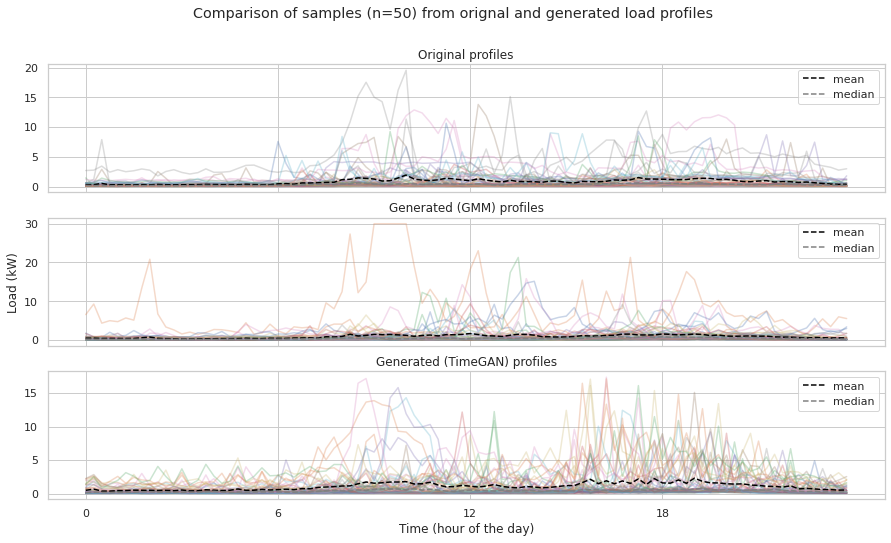

In [26]:
plot_random_generated_sample(real, gmm, timegan, start_dt, end_dt, n_profiles=50, resample_v='15min')

## Plot the distributions (with a boxplot) of the real and generated data

In [18]:
def evaluate_samples(ori_data, generated_data, timegan_data, start_dt, end_dt, resample_v='60min', n=3):
    df = get_combined_df(ori_data, generated_data, timegan_data, start_dt, end_dt, resample_v)
    df.rename(columns={'hour': 'Time (hour of the day)', 'verbruik': 'load (kW)'}, inplace=True)
    boxplot = sns.catplot(x='Time (hour of the day)', y='load (kW)', data=df, kind='box', col='type')
    fig = boxplot.fig
#     fig.suptitle("Custom Super Title")
    a1 = fig.axes[1]
    a1.set_title("GMM")
    a0 = fig.axes[0]
    a0.set_title("Real")
    a2 = fig.axes[2]
    a2.set_title("TimeGAN")
#     plt.ylim([0,40])
    
    plt.show()
    #

    df_agg = (
        df
        .reset_index()
        .groupby(['dt', 'type', 'Time (hour of the day)'])
        .agg({
           'load (kW)' : ['median', percentile(25), percentile(75), 'max']
        })
        .droplevel(0, axis=1)
        .reset_index()
        .melt(id_vars=['dt', 'type', 'Time (hour of the day)'], value_vars= [ 'percentile_25', 'median', 'percentile_75'], value_name='metric')
    )
    lineplot = sns.relplot(data=df_agg, x='Time (hour of the day)', y='metric', hue='type', col='variable', kind='line')
    fig = lineplot.fig
#     fig.suptitle("Custom Super Title")
    a1 = fig.axes[1]
    a1.set_title("Median")
    a0 = fig.axes[0]
    a0.set_title("First Quartile")
    a2 = fig.axes[2]
    a2.set_title("Third Quartile")
    
    plt.show()

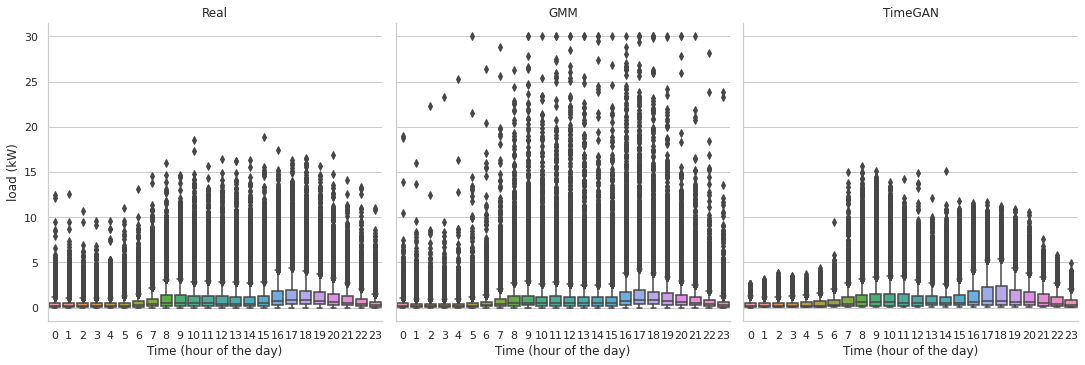

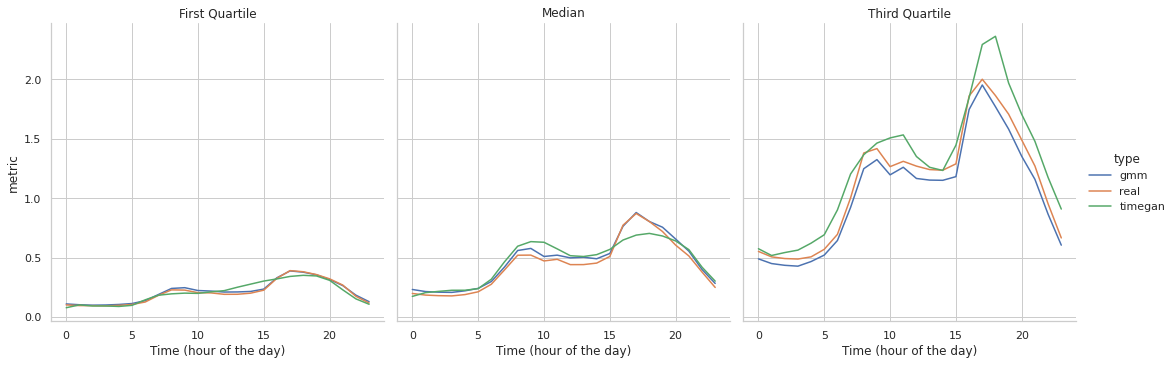

In [19]:
evaluate_samples(real, gmm, timegan, start_dt, end_dt, '60min')

## 

# Compare overall distributions

In [20]:
def compare_distibutions(ori_data, gmm_data, timegan_data, title='Comparison of the distributions', x='Load (kW)'):
    axis_fs = 13
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.suptitle(title)
    
    real = ori_data.reshape(-1)
    gmm = gmm_data.reshape(-1)
    timegan = timegan_data.reshape(-1)
    xmin = real.min()
    xmax = np.minimum(real.max(), 15)
    bins = np.linspace(xmin, xmax, 100)
    alpha = 0.5
    
    ax1.hist(real, bins, label='original', alpha=alpha)
    ax1.hist(gmm, bins, label='gmm', alpha=alpha)
    ax1.set_xlabel(x, fontsize=axis_fs)
    ax1.set_ylabel('Frequency', fontsize=axis_fs)
    ax1.legend()

    ax2.hist(real, bins, label='original', alpha=alpha)
    ax2.hist(timegan, bins, label='timegan', alpha=alpha)
    ax2.set_xlabel(x, fontsize=axis_fs)
    ax2.set_ylabel('Frequency', fontsize=axis_fs)
    ax2.legend()

    plt.show()

    
    # cumulitave plot
    s_real = np.sort(real)
    s_gmm = np.sort(gmm)
    s_timegan = np.sort(timegan)
    
    y = np.arange(len(real)) / float(len(real))
    # plotting
    plt.xlabel('load (kW)', fontsize=axis_fs)
    plt.ylabel('cumulative probability')

    plt.title('CDF comparison')

    plt.plot(s_real, y, '--',  label='original')
    plt.plot(s_gmm, y,  label='gmm')
    plt.plot(s_timegan, y,  label='timegan')
    plt.xlim([xmin, xmax])
    plt.legend()
#     plt.xlim([0, 10])
    plt.show()
    
    # perform Kolmogorov–Smirnov test
    d_gmm = perform_kstest(real, gmm)
    d_timegan= perform_kstest(real, timegan)
    print(f'GMM: D-statistic: {np.round(d_gmm, 3)}')
    print(f'Timegan: D-statistic: {np.round(d_timegan, 3)}')

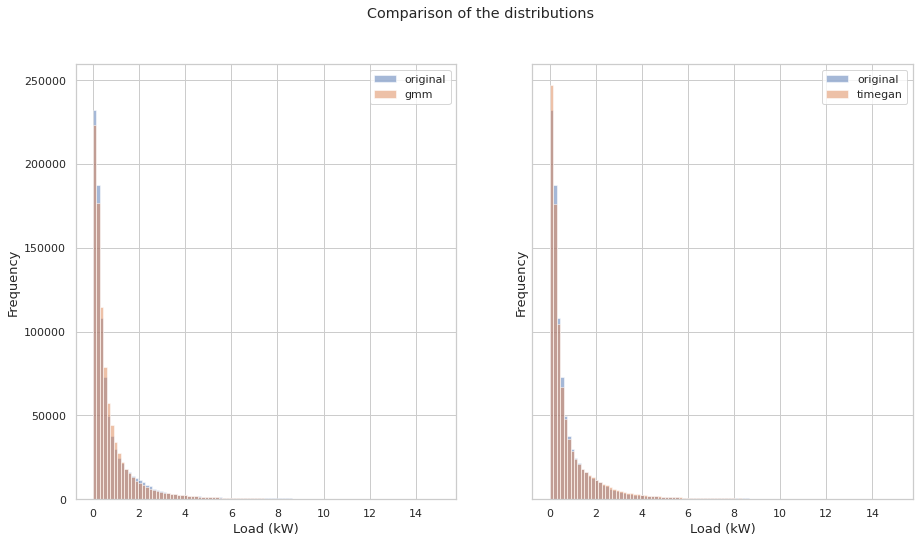

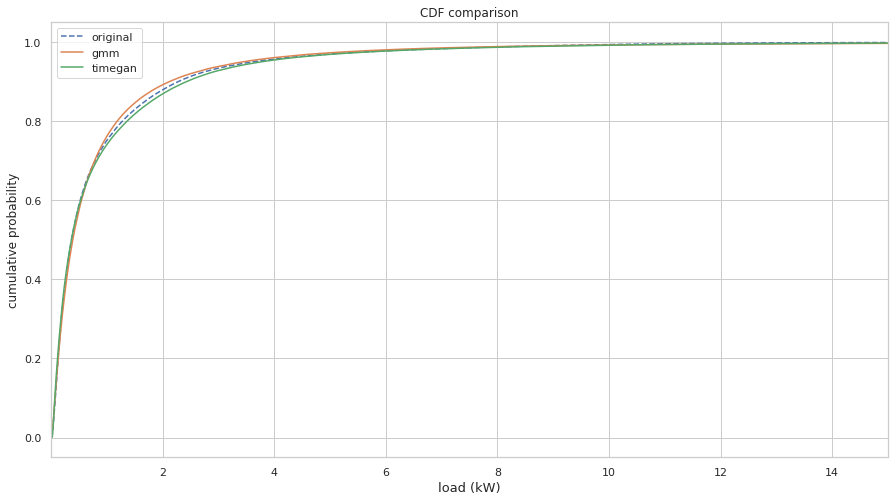

GMM: D-statistic: 0.022
Timegan: D-statistic: 0.023


In [21]:
compare_distibutions(real, gmm, timegan)

## Compare load of the distributions for several hours

In [22]:
def plot_multiple_hours(real, gmm, timegan, difference=True):
    
    real_whole_hours = real[:, ::4]
    gmm_whole_hours = gmm[:, ::4]
    timegan_whole_hours = timegan[:, ::4]
    
    # als de parameter difference op True staat; het verschil tussen de kwartierwaarden gebruiken ipv de waarde zelf
    if difference:
        real_whole_hours_15 = real[:max_profiles, 1::4]
        real_diffs = real_whole_hours_15 - real_whole_hours 
        real_whole_hours = real_diffs

        gmm_whole_hours_15 = gmm[:max_profiles, 1::4]
        gmm_diffs = gmm_whole_hours_15 - gmm_whole_hours
        gmm_whole_hours = gmm_diffs

        timegan_whole_hours_15 = timegan[:max_profiles, 1::4]
        timegan_diffs = timegan_whole_hours_15 - timegan_whole_hours
        timegan_whole_hours = timegan_diffs
    
    
    hours = [x for x in range(0,24,4)]
    fig, axs = plt.subplots(2, 3, sharey=True, sharex=True)
    

    h_index = 0
    for (i, ax) in enumerate(axs):
        for j in range(3):
            hour = hours[h_index]
            
            s_real = np.sort(real_whole_hours[:,h_index])
            s_gmm = np.sort(gmm_whole_hours[:, h_index])
            s_timegan = np.sort(timegan_whole_hours[:, h_index])

            y = np.arange(len(real)) / float(len(real))
            # plotting

            ax[j].set_ylabel('cumulative distribution')
            
            hour_str = f'0{hour}:00' if hour < 10 else f'{hour}:00'
            ax[j].set_title(f'CDF comparison for hour {hour_str}')


            ax[j].plot(s_real, y, '--',  label='original')
            ax[j].plot(s_gmm, y,  label='gmm')
            ax[j].plot(s_timegan, y,  label='timegan')
#             if difference:
#                 ax[j].set_xlim([-3, 3])
#             else:
#                 ax[j].set_xlim([0, 3])
            
            if i == 1:
                ax[j].set_xlabel('load (kW)')
            
            h_index += 1
    #         plt.legend()
        #     plt.xlim([0, 10])
    plt.legend()
    plt.show()


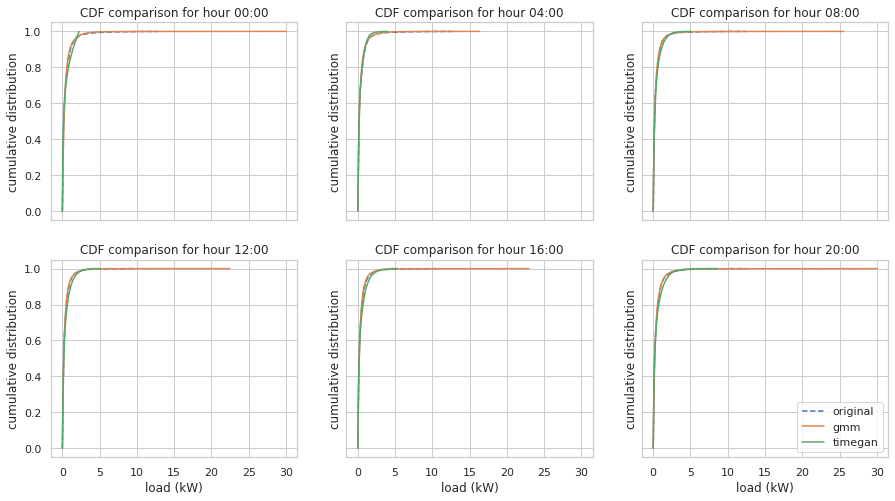

In [23]:
plot_multiple_hours(real, gmm, timegan, difference=False)

## Compare the difference between two consecutive time steps over all the profiles

In [24]:
def plot_hour_difference(real, gmm, timegan, hours, title, x):
    sample = np.random.choice(range(len(real)), size=len(real), replace=False)    
    gmm = gmm[sample,:]
    timegan = timegan[sample,:]
    # hour
    real_dis = real[:, (hours*4)+1] - real[:, hours*4]
    gmm_dis = gmm[:, (hours*4)+1] -  gmm[:, hours*4]
    timegan_dis = timegan[:, (hours*4)+1] -  timegan[:, hours*4]
    
    compare_distibutions(real_dis, gmm_dis, timegan_dis, title, x)

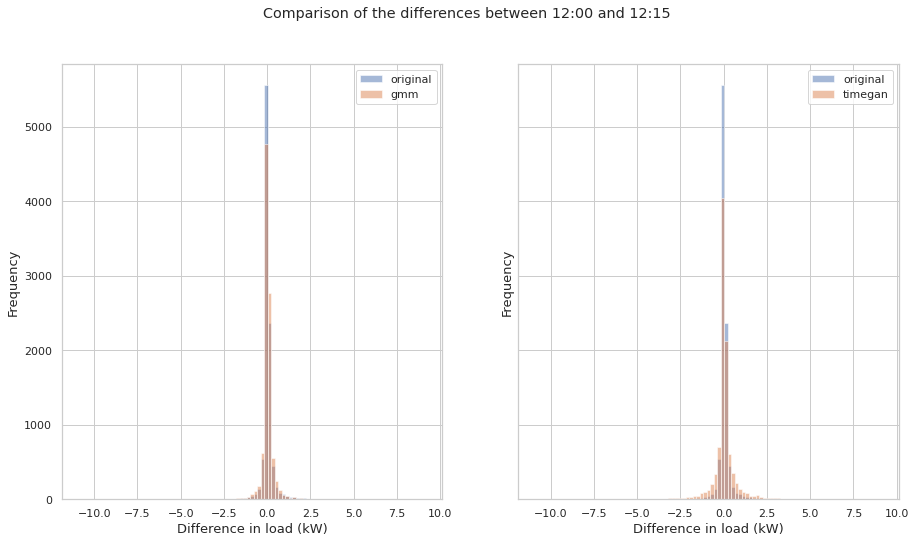

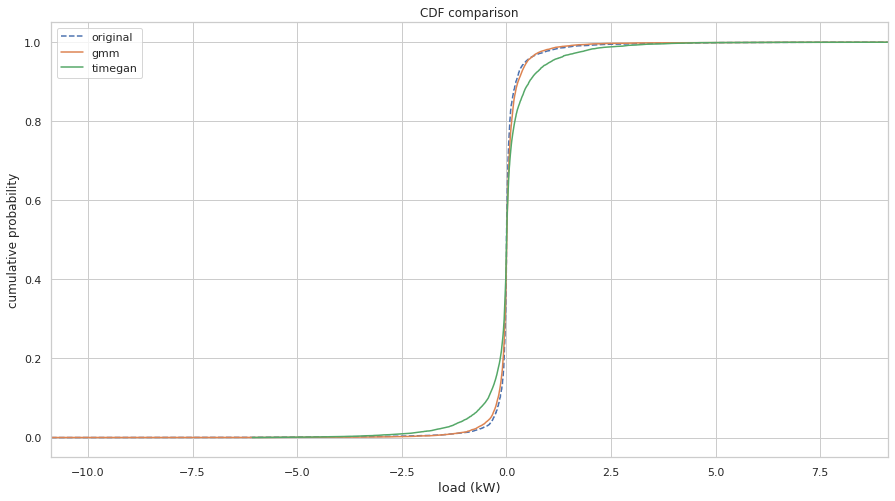

GMM: D-statistic: 0.071
Timegan: D-statistic: 0.109


In [25]:
plot_hour_difference(real, gmm, timegan, 6, title='Comparison of the differences between 12:00 and 12:15', x='Difference in load (kW)')

## normalied vs scaled (both days)

## Time complexity plot